<h1>Imports</h1>

In [1]:
import tensorflow as tf
TF_FORCE_GPU_ALLOW_GROWTH= True
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available. Using the CPU instead.")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import Dense , Dropout, BatchNormalization , GlobalAveragePooling2D , Conv2D , MaxPooling2D , Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , AveragePooling2D , Dropout
from tensorflow.keras.applications import MobileNetV2, VGG16, EfficientNetV2B0, EfficientNetV2B3


from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_explain.core.grad_cam import GradCAM as GradCAME
from tf_keras_vis.utils.model_modifiers import ModelModifier
from tf_keras_vis.utils.scores import CategoricalScore


from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from collections import Counter



2024-03-28 17:01:16.578559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 17:01:16.578585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 17:01:16.579367: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 17:01:16.583172: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 17:01:17.043428: W tensorflow/compiler/tf2

<h1> Load Dataset </h1>

In [2]:

trainining_data_path = 'brain_images/Training/' # Path to folder containing training image data
testing_data = 'brain_images/Testing/' # Path to folder containing testing image data

tf.random.set_seed(123)

BATCH_SIZE = 32 
IMAGE_SIZE = (160, 160)

image_paths_training = []
labels = []

for class_folder in os.listdir(trainining_data_path):
    class_folder_path = os.path.join(trainining_data_path, class_folder)
    if os.path.isdir(class_folder_path):
        for image_file in os.listdir(class_folder_path):
            if image_file.endswith('.jpg') or image_file.endswith('.png'):
                image_paths_training.append(os.path.join(class_folder_path, image_file))
                labels.append(class_folder)

image_paths_testing = []
testing_labels = []

for class_folder in os.listdir(testing_data):
    class_folder_path = os.path.join(testing_data, class_folder)
    if os.path.isdir(class_folder_path):
        for image_file in os.listdir(class_folder_path):
            if image_file.endswith('.jpg') or image_file.endswith('.png'):
                image_paths_testing.append(os.path.join(class_folder_path, image_file))
                testing_labels.append(class_folder)

print("Number of training images: ", len(image_paths_training))
print("Number of testing images: ", len(image_paths_testing))

label_counts_training = Counter(labels)
print("Label counts in training data: ", label_counts_training)

label_counts_testing = Counter(testing_labels)
print("Label counts in testing data: ", label_counts_testing)


Number of training images:  5712
Number of testing images:  1311
Label counts in training data:  Counter({'notumor': 1595, 'pituitary': 1457, 'meningioma': 1339, 'glioma': 1321})
Label counts in testing data:  Counter({'notumor': 405, 'meningioma': 306, 'pituitary': 300, 'glioma': 300})


<h1> Visualising Dataset</h1>

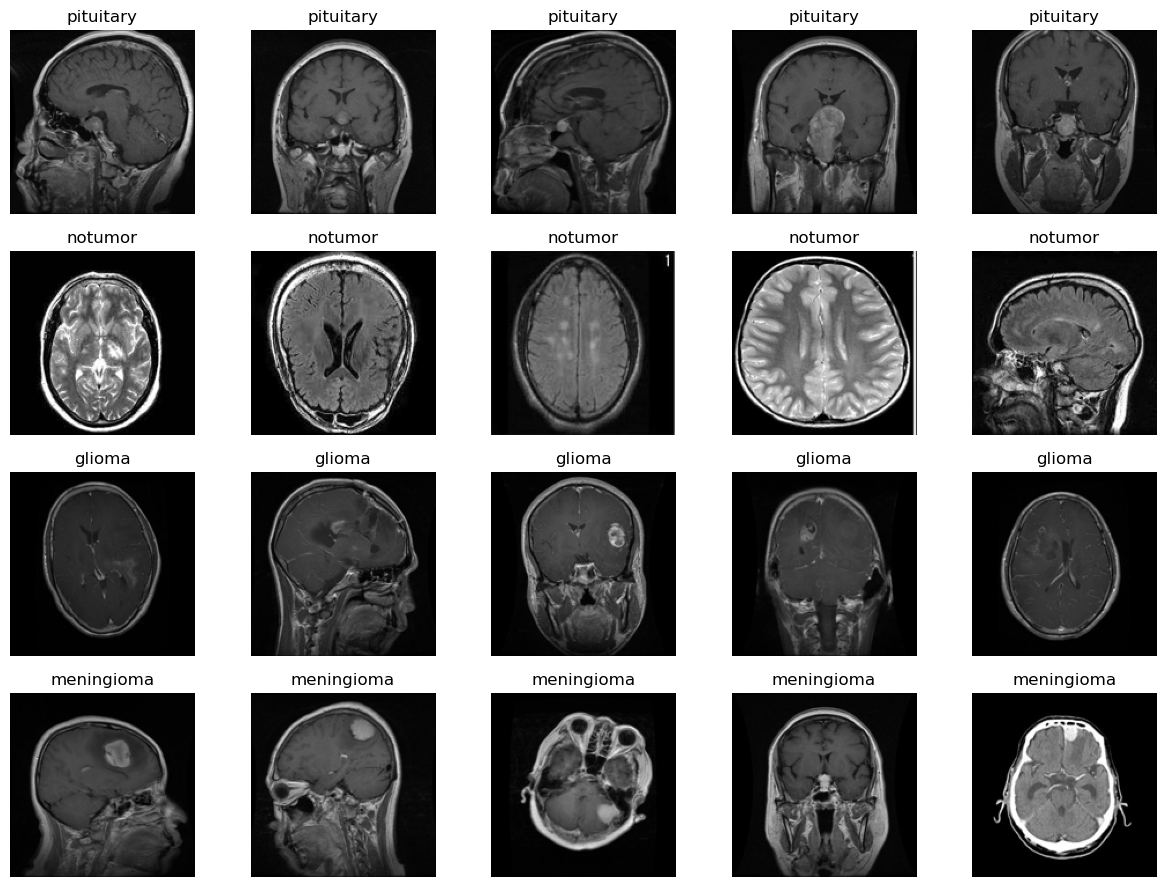

In [3]:
from PIL import Image
from collections import defaultdict

def load_images(image_paths, target_size):
    return np.array([np.array(Image.open(path).convert('RGB').resize(target_size)) for path in image_paths])

def plotImages(images, labels):
    plt.figure(figsize=[15,11])                 
    
    images_by_class = defaultdict(list)
    for image, label in zip(images, labels):
        images_by_class[label].append(image)
    
    selected_images = [image for images in images_by_class.values() for image in images[:5]]
    selected_labels = [label for label, images in images_by_class.items() for image in images[:5]]
    
    for i in range(len(selected_images)):
        plt.subplot(len(images_by_class), 5, i+1)  
        plt.imshow(selected_images[i])             
        plt.title(selected_labels[i])              
        plt.axis("off")
    plt.show()

images = load_images(image_paths_training, IMAGE_SIZE)

plotImages(images, labels)

Visualise dataset after removing black borders

<h1> Model </h1>

<h3> EfficientNetV2B0 </h3>

In [4]:
from keras.regularizers import l2
from keras.layers import Input
from keras.optimizers import Adam

def create_model():
    dropout_rate = 0.5 

    

    input_tensor = Input(shape=IMAGE_SIZE + (3,))
    EfficientNetV2B0_model = EfficientNetV2B0(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False, input_tensor=input_tensor)

    for layer in EfficientNetV2B0_model.layers:
        layer.trainable = False
    
    EfficientNetV2B0_model.layers[-2].trainable = True
    EfficientNetV2B0_model.layers[-3].trainable = True
    EfficientNetV2B0_model.layers[-4].trainable = True

    out_relu = EfficientNetV2B0_model.layers[-1]
    x = Flatten()(out_relu.output)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(4, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    
    return model

<h3>MobileNetV2</h1>

In [5]:
def MobileNetV2_create_model():
    dropout_rate = 0.5 

    input_tensor = Input(shape=IMAGE_SIZE + (3,))
    MobileNetV2_model = MobileNetV2(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False, input_tensor=input_tensor)

    out_relu = MobileNetV2_model.layers[-1]
    x = Flatten()(out_relu.output)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(4, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    
    return model

<h1>K-cross validation</h1>

In [13]:

from textwrap import fill
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

skf = StratifiedKFold(n_splits=5 ,shuffle=True, random_state=123)

models_and_scores = []
class_names = []

MobileNetV2_models_and_scores = []

test_generator = None

number_of_epochs = 15

for train_index, val_index in skf.split(image_paths_training, labels):
    train_paths, val_paths = np.array(image_paths_training)[train_index], np.array(image_paths_training)[val_index]
    train_labels, val_labels = np.array(labels)[train_index], np.array(labels)[val_index]
    
    
    train_df = pd.DataFrame({'path': train_paths, 'label': train_labels})
    val_df = pd.DataFrame({'path': val_paths, 'label': val_labels})
    test_df = pd.DataFrame({'path': image_paths_testing, 'label': testing_labels})

    print("Train class distribution: ", train_df['label'].value_counts())
    
    train_datagen = IDG(horizontal_flip=True, vertical_flip=True, cval=0, fill_mode='constant', zoom_range=0.1, rotation_range=10)
    
    train_datagen_rescaled = IDG(
                rescale=1./255,
                shear_range= 0.3,  
                zoom_range = 0.4,  
                width_shift_range = 0.3,  
                height_shift_range = 0.3,
                fill_mode = "nearest")
    

    val_datagen = IDG( )

    val_datagen_rescaled = IDG(
                rescale=1./255,)
    

    test_datagen = IDG()

    test_datagen_rescaled = IDG(
                rescale=1./255,
    )

    train_generator = train_datagen.flow_from_dataframe(train_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb')
    val_generator = val_datagen.flow_from_dataframe(val_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb')
    test_generator = test_datagen.flow_from_dataframe(test_df, x_col='path', y_col='label', target_size=IMAGE_SIZE, class_mode='categorical', shuffle=True, color_mode='rgb')

    class_names = list(test_generator.class_indices)
    
    model = create_model()
    modelM = MobileNetV2_create_model()  

    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = dict(enumerate(class_weights))

    model.fit(train_generator, epochs=number_of_epochs, validation_data=val_generator,  verbose = 1)
    modelM.fit(train_generator, epochs=number_of_epochs, validation_data=val_generator,  verbose = 1)

    score = model.evaluate(test_generator)
    MobileNetV2_score = modelM.evaluate(test_generator)
    print(f"EfficientNetV2B0 score: {score}")
    print(f"MobileNetV2 score: {MobileNetV2_score}")

    models_and_scores.append((model, score))
    MobileNetV2_models_and_scores.append((modelM, MobileNetV2_score))

best_model, best_score = max(models_and_scores, key=lambda x: x[1][1])
best_MobileNetV2_model, best_MobileNetV2_score = max(MobileNetV2_models_and_scores, key=lambda x: x[1][1])

print(f"Best model: {best_model}, score: {best_score}")
print(f"Best MobileNetV2 model: {best_MobileNetV2_model}, score: {best_MobileNetV2_score}")

Train class distribution:  label
notumor       1276
pituitary     1165
meningioma    1071
glioma        1057
Name: count, dtype: int64
Found 4569 validated image filenames belonging to 4 classes.


Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.
Epoch 1/15
143/143 [==============================] - 23s 139ms/step - loss: 0.6412 - accuracy: 0.7673 - val_loss: 0.4174 - val_accuracy: 0.8600
Epoch 2/15
143/143 [==============================] - 18s 128ms/step - loss: 0.4069 - accuracy: 0.8461 - val_loss: 0.3362 - val_accuracy: 0.8863
Epoch 3/15
143/143 [==============================] - 18s 124ms/step - loss: 0.3225 - accuracy: 0.8763 - val_loss: 0.2888 - val_accuracy: 0.9064
Epoch 4/15
143/143 [==============================] - 17s 117ms/step - loss: 0.2589 - accuracy: 0.9026 - val_loss: 0.2902 - val_accuracy: 0.9038
Epoch 5/15
143/143 [==============================] - 18s 127ms/step - loss: 0.2801 - accuracy: 0.9024 - val_loss: 0.2484 - val_accuracy: 0.9090
Epoch 6/15
143/143 [==============================] - 18s 126ms/step - loss: 0.2395 - accuracy: 0.9098 - val_loss: 0.2386 - val_accuracy: 0.9125
Epoch 7/

2024-03-28 18:37:57.619268: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_109/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 22s 132ms/step - loss: 0.6516 - accuracy: 0.7728 - val_loss: 0.3337 - val_accuracy: 0.8871
Epoch 2/15
143/143 [==============================] - 18s 124ms/step - loss: 0.3909 - accuracy: 0.8619 - val_loss: 0.3074 - val_accuracy: 0.8915
Epoch 3/15
143/143 [==============================] - 19s 130ms/step - loss: 0.3371 - accuracy: 0.8790 - val_loss: 0.2083 - val_accuracy: 0.9265
Epoch 4/15
143/143 [==============================] - 18s 126ms/step - loss: 0.2827 - accuracy: 0.8934 - val_loss: 0.2472 - val_accuracy: 0.9108
Epoch 5/15
143/143 [==============================] - 18s 125ms/step - loss: 0.2518 - accuracy: 0.9026 - val_loss: 0.1798 - val_accuracy: 0.9414
Epoch 6/15
143/143 [==============================] - 18s 125ms/step - loss: 0.2356 - accuracy: 0.9125 - val_loss: 0.1907 - val_accuracy: 0.9318
Epoch 7/15
143/143 [==============================] - 17s 121ms/step - loss: 0.2156 - accuracy: 0.9168 - val_loss: 0.2090 - val_accuracy: 0.9

2024-03-28 18:47:15.354613: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_111/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 22s 131ms/step - loss: 0.6800 - accuracy: 0.7538 - val_loss: 0.3956 - val_accuracy: 0.8678
Epoch 2/15
143/143 [==============================] - 17s 120ms/step - loss: 0.3988 - accuracy: 0.8547 - val_loss: 0.3024 - val_accuracy: 0.9011
Epoch 3/15
143/143 [==============================] - 18s 122ms/step - loss: 0.3447 - accuracy: 0.8768 - val_loss: 0.2347 - val_accuracy: 0.9212
Epoch 4/15
143/143 [==============================] - 17s 121ms/step - loss: 0.3032 - accuracy: 0.8853 - val_loss: 0.2747 - val_accuracy: 0.9124
Epoch 5/15
143/143 [==============================] - 18s 123ms/step - loss: 0.2846 - accuracy: 0.8941 - val_loss: 0.2689 - val_accuracy: 0.9186
Epoch 6/15
143/143 [==============================] - 18s 123ms/step - loss: 0.2420 - accuracy: 0.9105 - val_loss: 0.2887 - val_accuracy: 0.9142
Epoch 7/15
143/143 [==============================] - 18s 127ms/step - loss: 0.2405 - accuracy: 0.9098 - val_loss: 0.2623 - val_accuracy: 0.9

2024-03-28 18:56:29.362619: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_113/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 24s 132ms/step - loss: 0.6497 - accuracy: 0.7639 - val_loss: 0.2848 - val_accuracy: 0.8862
Epoch 2/15
143/143 [==============================] - 18s 129ms/step - loss: 0.3770 - accuracy: 0.8589 - val_loss: 0.2906 - val_accuracy: 0.8984
Epoch 3/15
143/143 [==============================] - 18s 124ms/step - loss: 0.3296 - accuracy: 0.8735 - val_loss: 0.2523 - val_accuracy: 0.9142
Epoch 4/15
143/143 [==============================] - 17s 120ms/step - loss: 0.2818 - accuracy: 0.9000 - val_loss: 0.2513 - val_accuracy: 0.9186
Epoch 5/15
143/143 [==============================] - 17s 122ms/step - loss: 0.2582 - accuracy: 0.9026 - val_loss: 0.2441 - val_accuracy: 0.9308
Epoch 6/15
143/143 [==============================] - 18s 123ms/step - loss: 0.2348 - accuracy: 0.9138 - val_loss: 0.2401 - val_accuracy: 0.9203
Epoch 7/15
143/143 [==============================] - 18s 125ms/step - loss: 0.2177 - accuracy: 0.9188 - val_loss: 0.2519 - val_accuracy: 0.9

2024-03-28 19:05:41.362412: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_115/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 22s 128ms/step - loss: 0.6945 - accuracy: 0.7584 - val_loss: 0.3705 - val_accuracy: 0.8704
Epoch 2/15
143/143 [==============================] - 18s 125ms/step - loss: 0.3851 - accuracy: 0.8593 - val_loss: 0.2927 - val_accuracy: 0.8967
Epoch 3/15
143/143 [==============================] - 18s 123ms/step - loss: 0.3155 - accuracy: 0.8803 - val_loss: 0.2329 - val_accuracy: 0.9177
Epoch 4/15
143/143 [==============================] - 18s 124ms/step - loss: 0.2852 - accuracy: 0.8978 - val_loss: 0.2274 - val_accuracy: 0.9159
Epoch 5/15
143/143 [==============================] - 18s 122ms/step - loss: 0.2583 - accuracy: 0.9055 - val_loss: 0.2030 - val_accuracy: 0.9229
Epoch 6/15
143/143 [==============================] - 18s 126ms/step - loss: 0.2353 - accuracy: 0.9127 - val_loss: 0.1975 - val_accuracy: 0.9273
Epoch 7/15
143/143 [==============================] - 18s 128ms/step - loss: 0.2051 - accuracy: 0.9245 - val_loss: 0.1780 - val_accuracy: 0.9

<h1> Scores </h1>

In [19]:

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

images_list, labels_list = [], []
columns = 5
rows = 4

for _ in range(len(test_generator)):
    images_batch, labels_batch = next(test_generator)
    images_list.extend(images_batch)
    labels_list.extend(labels_batch)


indices = np.random.choice(len(images_list), size=20, replace=False)


random_images = np.array([images_list[i] for i in indices])
random_labels = [labels_list[i] for i in indices]




predictions = best_model.predict(random_images)
MobileNetV2_predictions = best_MobileNetV2_model.predict(random_images)


evaluations = best_model.evaluate(random_images, np.array(random_labels))
MobileNetV2_evaluations = best_MobileNetV2_model.evaluate(random_images, np.array(random_labels))


#random_images = np.array([(image - np.min(image)) / (np.max(image) - np.min(image)) for image in random_images])


predicted_classes = np.argmax(predictions, axis=1)
MobileNetV2_predicted_classes = np.argmax(MobileNetV2_predictions, axis=1)

actual_classes = [np.argmax(label) for label in random_labels]


EfficientNetV2B0_f1 = f1_score(actual_classes, predicted_classes, average='weighted')
MobileNetV2_f1 = f1_score(actual_classes, MobileNetV2_predicted_classes, average='weighted')


EfficientNetV2B0_precision = precision_score(actual_classes, predicted_classes, average='weighted')
MobileNetV2_precision = precision_score(actual_classes, MobileNetV2_predicted_classes, average='weighted')


EfficientNetV2B0_recall = recall_score(actual_classes, predicted_classes, average='weighted')
MobileNetV2_recall = recall_score(actual_classes, MobileNetV2_predicted_classes, average='weighted')


EfficientNetV2B0_accuracy = accuracy_score(actual_classes, predicted_classes)
MobileNetV2_accuracy = accuracy_score(actual_classes, MobileNetV2_predicted_classes)

print(f"EfficientNetV2B0 f1 score: {EfficientNetV2B0_f1}")
print(f"MobileNetV2 f1 score: {MobileNetV2_f1}")

print(f"EfficientNetV2B0 precision score: {EfficientNetV2B0_precision}")
print(f"MobileNetV2 precision score: {MobileNetV2_precision}")

print(f"EfficientNetV2B0 recall score: {EfficientNetV2B0_recall}")
print(f"MobileNetV2 recall score: {MobileNetV2_recall}")

print(f"EfficientNetV2B0 accuracy score: {EfficientNetV2B0_accuracy}")
print(f"MobileNetV2 accuracy score: {MobileNetV2_accuracy}")



1/1 [==============================] - 0s 18ms/step - loss: 0.1692 - accuracy: 0.9500
EfficientNetV2B0 f1 score: 1.0
MobileNetV2 f1 score: 0.943939393939394
EfficientNetV2B0 precision score: 1.0
MobileNetV2 precision score: 0.9583333333333334
EfficientNetV2B0 recall score: 1.0
MobileNetV2 recall score: 0.95
EfficientNetV2B0 accuracy score: 1.0
MobileNetV2 accuracy score: 0.95


<h1> Grad-Cam</h1>

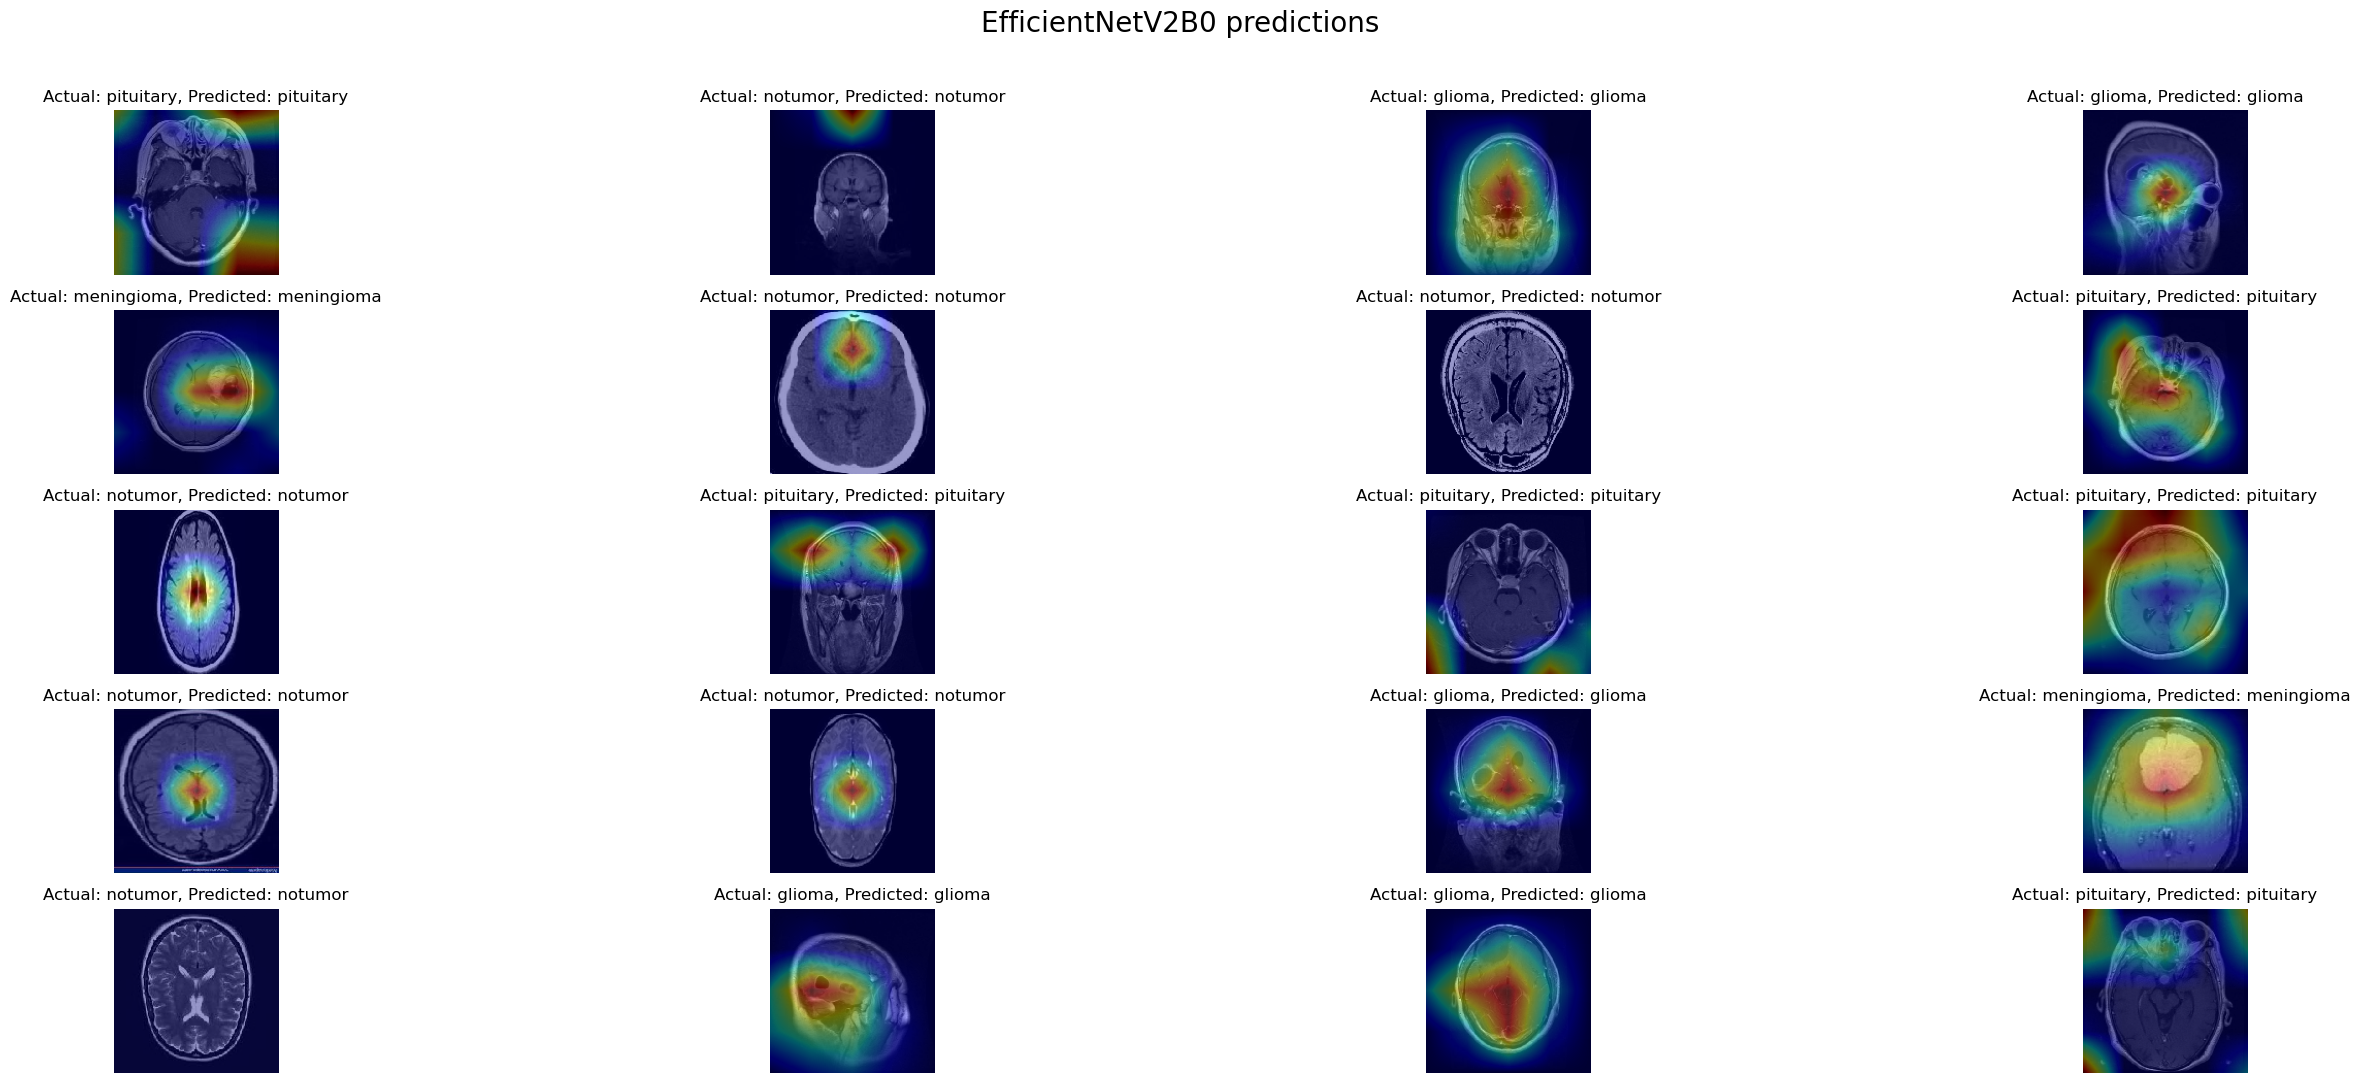

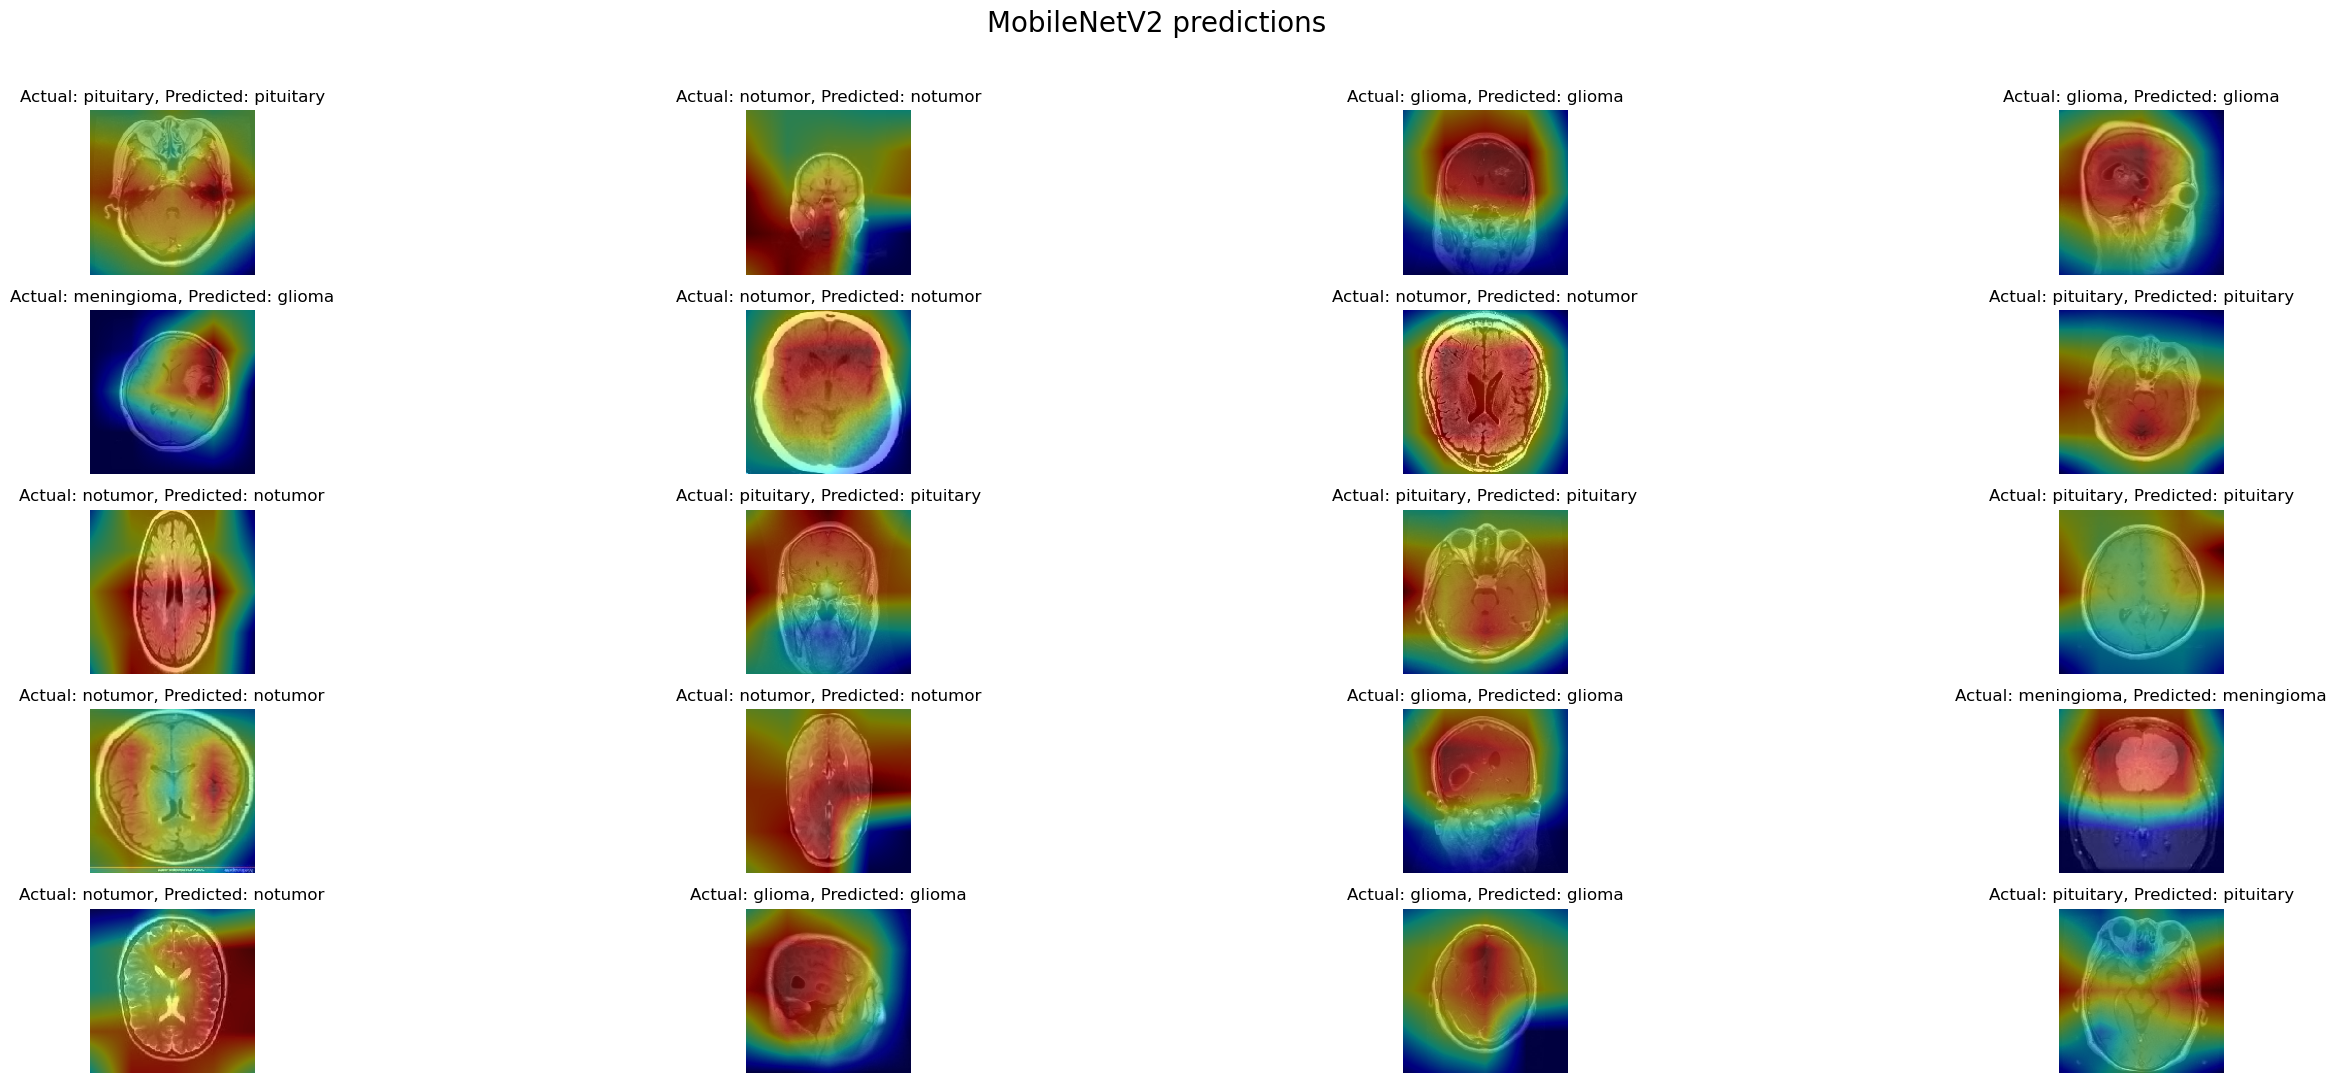

In [21]:
from turtle import mode
from tf_keras_vis.utils.scores import CategoricalScore


gradcam = Gradcam(best_model, model_modifier=ReplaceToLinear(), clone=True)  

plt.figure(figsize=(30, 11))
plt.suptitle("EfficientNetV2B0 predictions", fontsize=20)


for i, (image, actual_class, predicted_class) in enumerate(zip(random_images, actual_classes, predicted_classes)):

    score = CategoricalScore([predicted_class])

    heatmap = gradcam(score, np.array([image]))

    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))

    plt.subplot(columns, rows, i + 1)
    
    plt.imshow(normalized_image, alpha=1.0)
    
    plt.imshow(heatmap[0], cmap='jet', alpha=0.4)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


gradcam = Gradcam(best_MobileNetV2_model, model_modifier=ReplaceToLinear(), clone=False)

plt.figure(figsize=(30, 11))
plt.suptitle("MobileNetV2 predictions", fontsize=20)

for i, (image, actual_class, predicted_class) in enumerate(zip(random_images, actual_classes, MobileNetV2_predicted_classes)):
    score = CategoricalScore([predicted_class])

    heatmap = gradcam(score, np.array([image]),)

    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))

    plt.subplot(columns, rows, i + 1)
    
    plt.imshow(normalized_image, alpha=1.0)
    
    plt.imshow(heatmap[0], cmap='jet', alpha=0.5)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<h1> GradCamPlusPlus </h1>

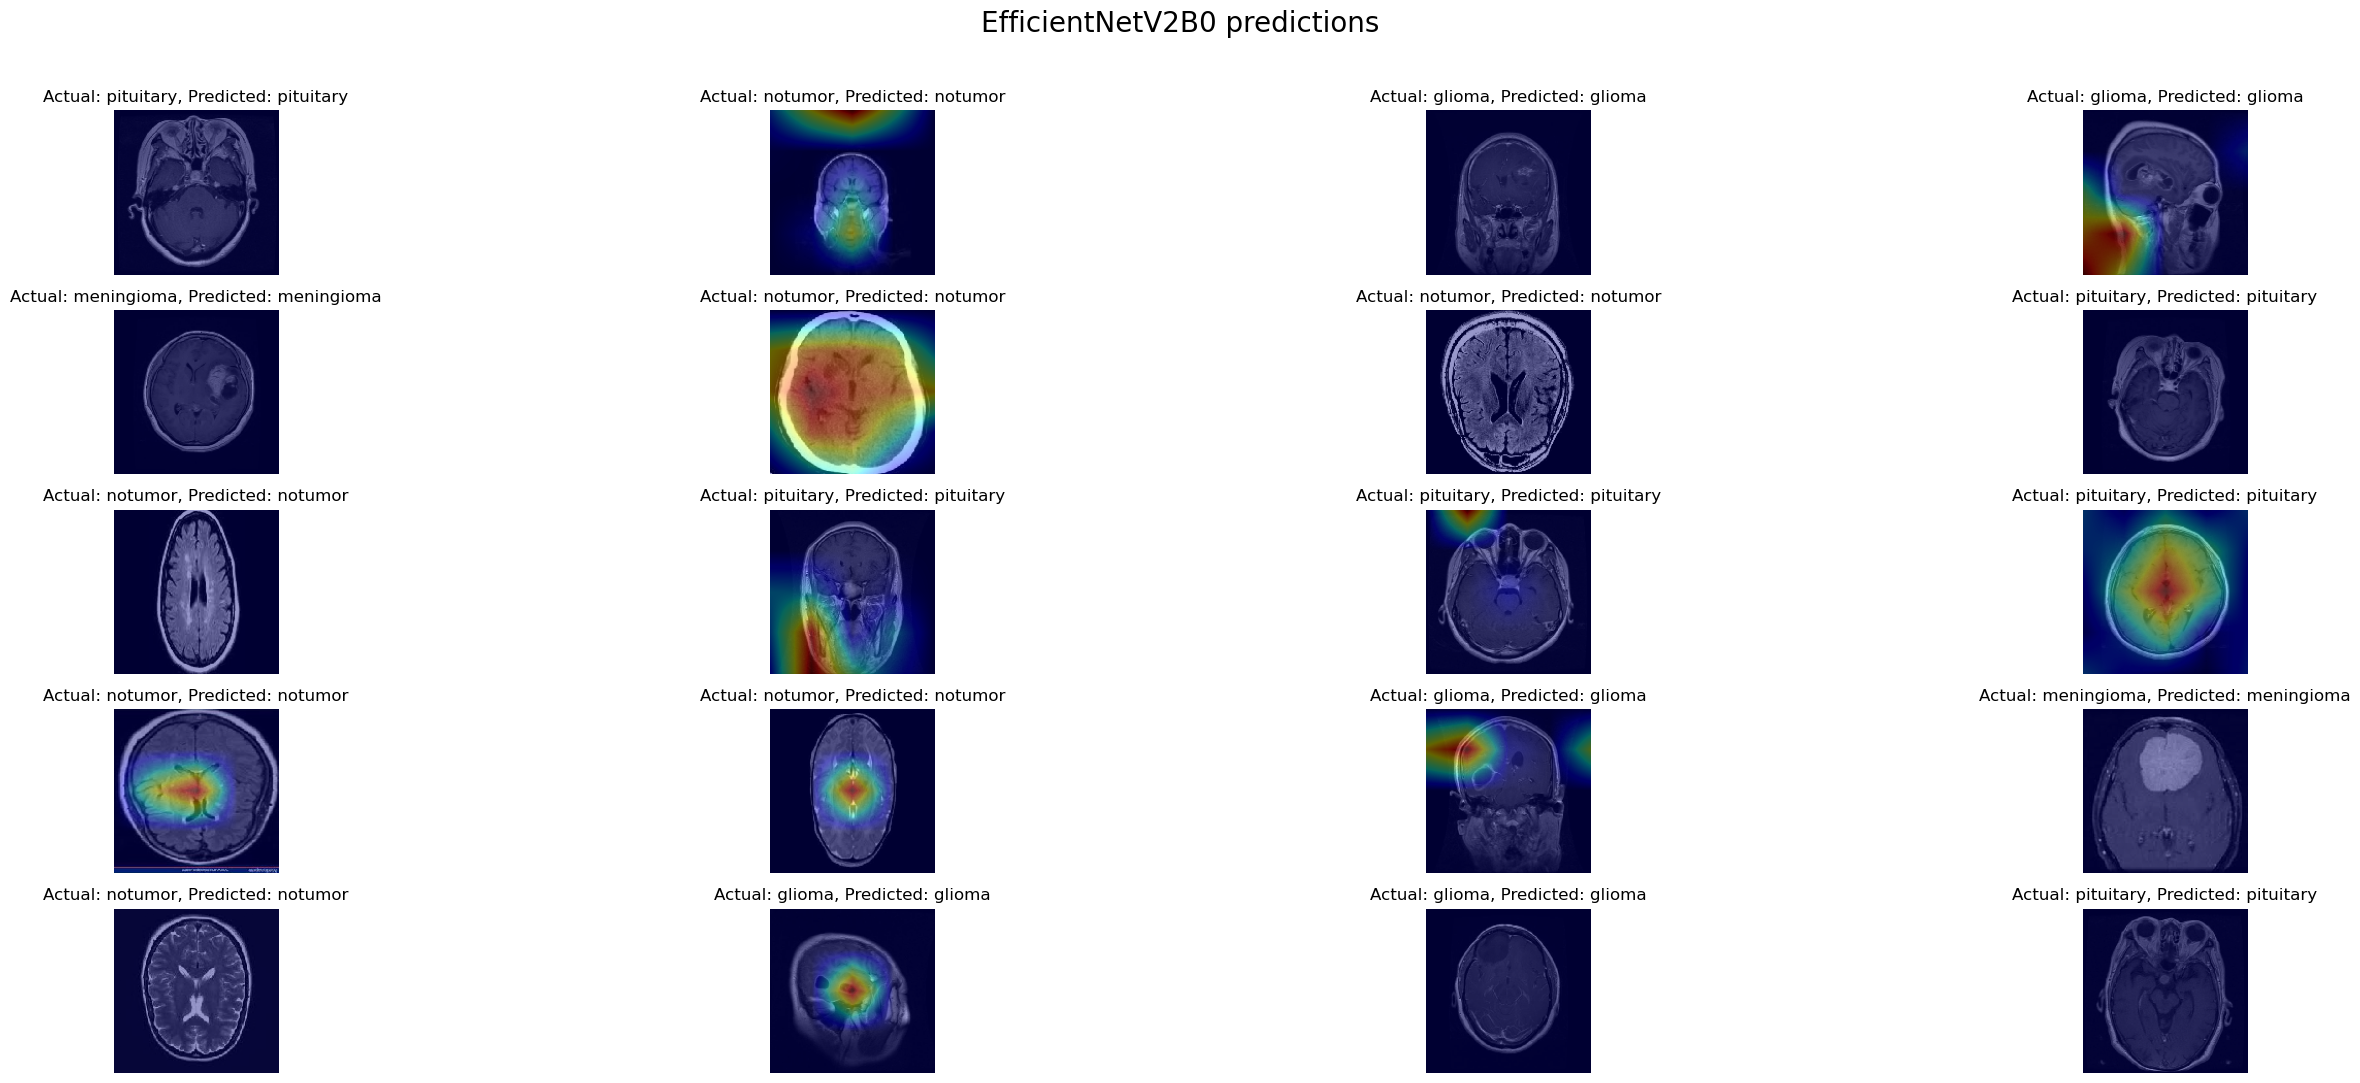

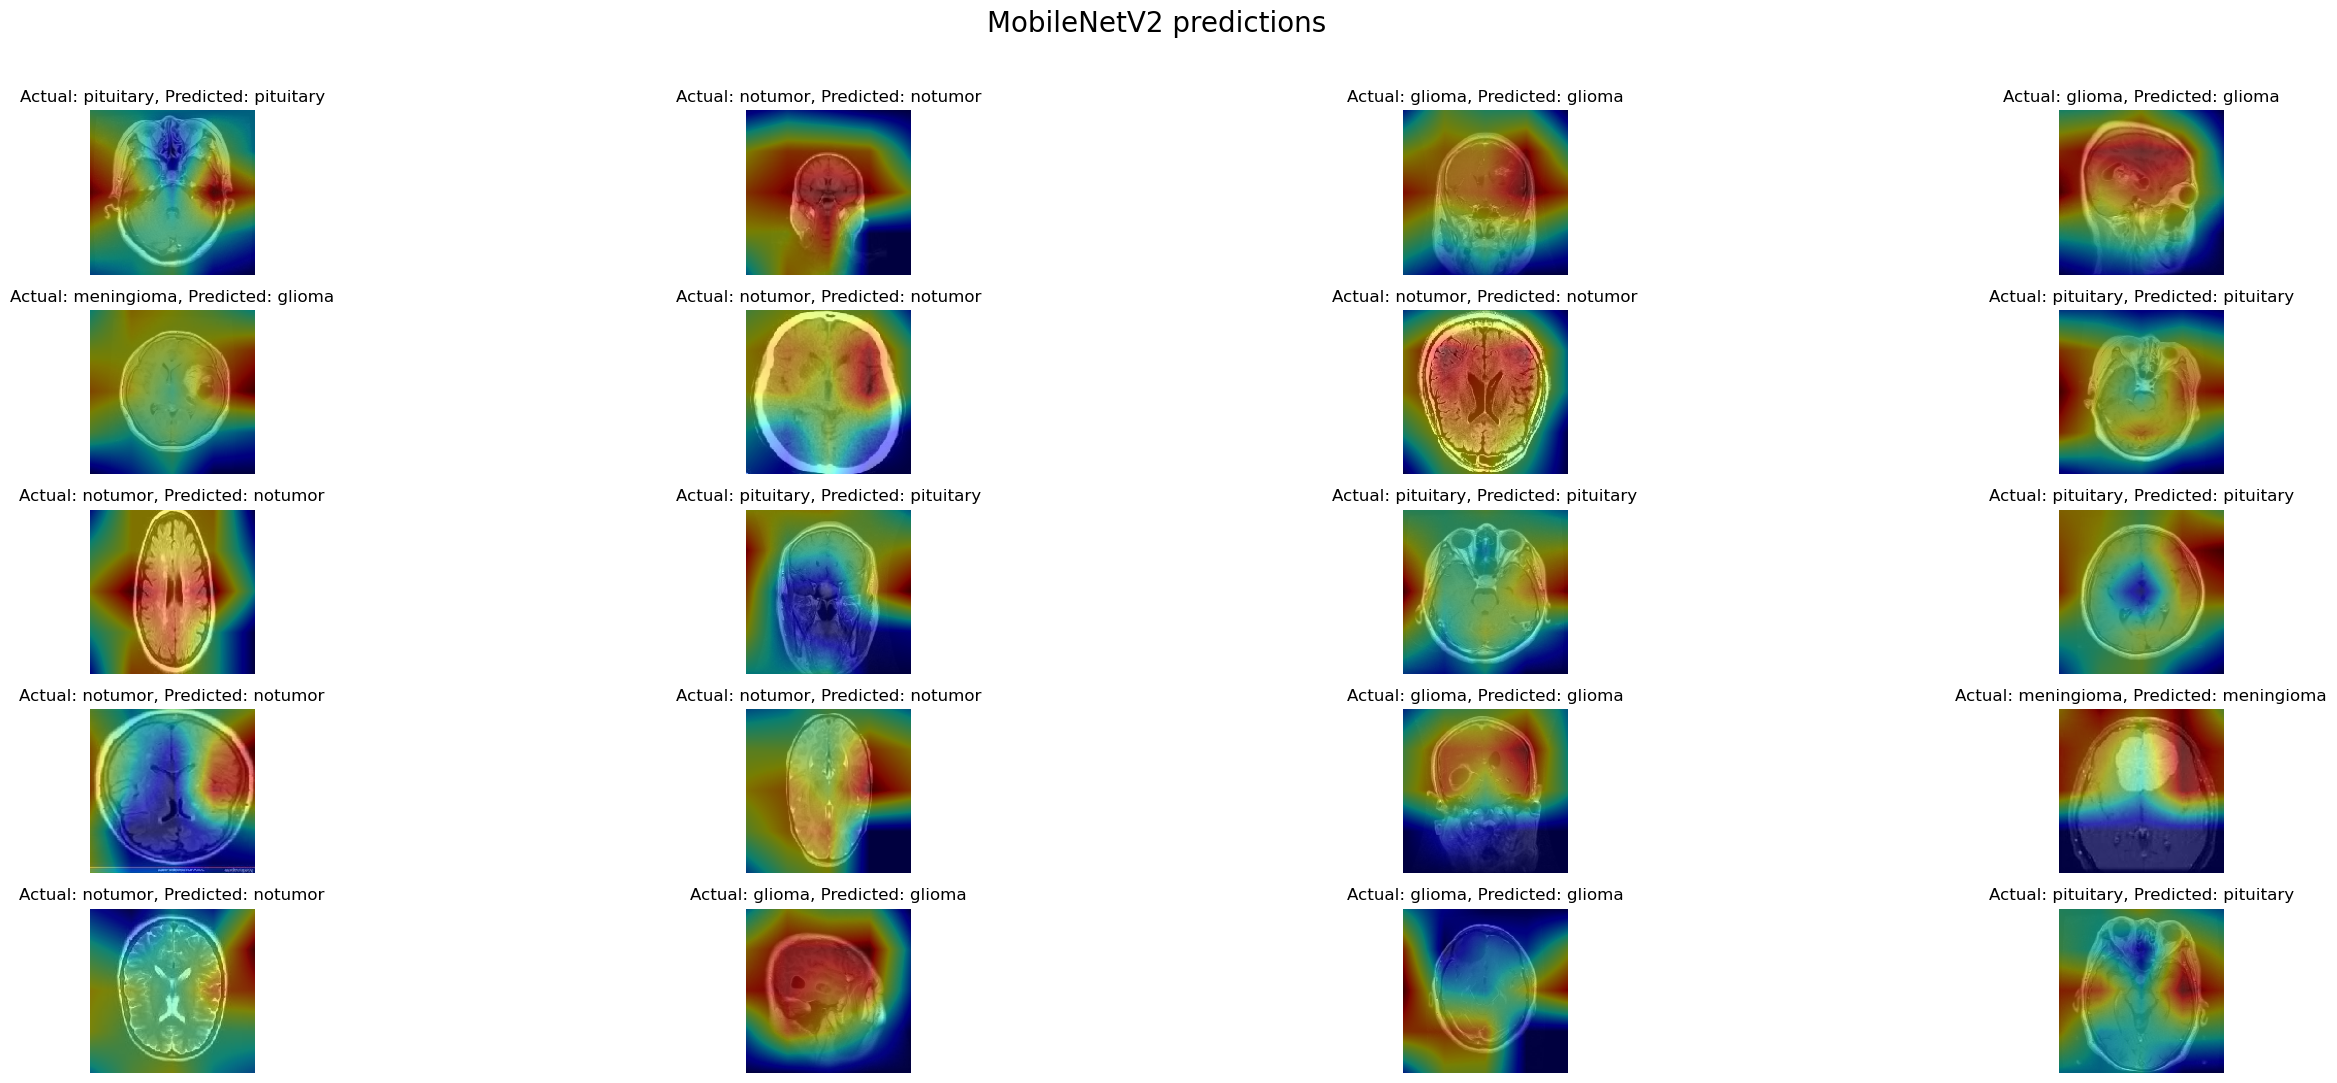

In [39]:
EfficientNetV2B0_gradcam_plus_plus = GradcamPlusPlus(best_model, model_modifier=ReplaceToLinear(), clone=False)

plt.figure(figsize=(30, 11))
plt.suptitle("EfficientNetV2B0 predictions", fontsize=20)


for i, (image, actual_class, predicted_class) in enumerate(zip(random_images, actual_classes, predicted_classes)):

    score = CategoricalScore([predicted_class])

    heatmap = EfficientNetV2B0_gradcam_plus_plus(score, np.array([image]),)

    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))

    plt.subplot(columns, rows, i + 1)
    
    plt.imshow(normalized_image, alpha=1.0)
    
    plt.imshow(heatmap[0], cmap='jet', alpha=0.4)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


MobileNetV2_gradcam_plus_plus = GradcamPlusPlus(best_MobileNetV2_model, model_modifier=ReplaceToLinear(), clone=False)

plt.figure(figsize=(30, 11))
plt.suptitle("MobileNetV2 predictions", fontsize=20)

for i, (image, actual_class, predicted_class) in enumerate(zip(random_images, actual_classes, MobileNetV2_predicted_classes)):
    score = CategoricalScore([predicted_class])

    heatmap = MobileNetV2_gradcam_plus_plus(score, np.array([image]),)

    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))

    plt.subplot(columns, rows, i + 1)
    
    plt.imshow(normalized_image, alpha=1.0)
    
    plt.imshow(heatmap[0], cmap='jet', alpha=0.5)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")
    
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



<h1>Lime</h1>

  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


  7%|▋         | 22/300 [00:00<00:01, 219.53it/s]

1/1 [==============================] - 0s 14ms/step


 17%|█▋        | 50/300 [00:00<00:01, 219.58it/s]

1/1 [==============================] - 0s 14ms/step


 27%|██▋       | 80/300 [00:00<00:00, 226.57it/s]

1/1 [==============================] - 0s 14ms/step


 37%|███▋      | 110/300 [00:00<00:00, 228.87it/s]

1/1 [==============================] - 0s 15ms/step


 47%|████▋     | 140/300 [00:00<00:00, 227.49it/s]

1/1 [==============================] - 0s 14ms/step


 54%|█████▍    | 163/300 [00:00<00:00, 227.58it/s]

1/1 [==============================] - 0s 13ms/step


 63%|██████▎   | 190/300 [00:00<00:00, 221.87it/s]

1/1 [==============================] - 0s 14ms/step


 73%|███████▎  | 220/300 [00:00<00:00, 223.20it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 243/300 [00:01<00:00, 218.20it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 270/300 [00:01<00:00, 213.35it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 221.91it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 236.00it/s]

1/1 [==============================] - 0s 14ms/step


 20%|██        | 60/300 [00:00<00:01, 232.20it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███       | 90/300 [00:00<00:00, 233.38it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 238.47it/s]

1/1 [==============================] - 0s 15ms/step


 50%|█████     | 150/300 [00:00<00:00, 234.00it/s]

1/1 [==============================] - 0s 15ms/step


 60%|██████    | 180/300 [00:00<00:00, 229.87it/s]

1/1 [==============================] - 0s 14ms/step


 70%|███████   | 210/300 [00:00<00:00, 231.85it/s]

1/1 [==============================] - 0s 14ms/step


 80%|████████  | 240/300 [00:01<00:00, 232.54it/s]

1/1 [==============================] - 0s 14ms/step


 90%|█████████ | 270/300 [00:01<00:00, 234.89it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 294/300 [00:01<00:00, 231.44it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 300/300 [00:01<00:00, 229.18it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 30/300 [00:00<00:01, 241.71it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 60/300 [00:00<00:00, 242.68it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 90/300 [00:00<00:00, 240.64it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 241.72it/s]

1/1 [==============================] - 0s 14ms/step


 50%|█████     | 150/300 [00:00<00:00, 238.53it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████    | 180/300 [00:00<00:00, 237.54it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 210/300 [00:00<00:00, 234.10it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 240/300 [00:01<00:00, 236.94it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 270/300 [00:01<00:00, 240.01it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 238.95it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 30/300 [00:00<00:01, 219.74it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█▋        | 52/300 [00:00<00:01, 218.42it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 80/300 [00:00<00:00, 227.02it/s]

1/1 [==============================] - 0s 14ms/step


 37%|███▋      | 110/300 [00:00<00:00, 229.78it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 140/300 [00:00<00:00, 227.19it/s]

1/1 [==============================] - 0s 15ms/step


 57%|█████▋    | 170/300 [00:00<00:00, 229.43it/s]

1/1 [==============================] - 0s 13ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 228.90it/s]

1/1 [==============================] - 0s 14ms/step


 77%|███████▋  | 230/300 [00:01<00:00, 231.10it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 260/300 [00:01<00:00, 234.50it/s]

1/1 [==============================] - 0s 14ms/step


 97%|█████████▋| 290/300 [00:01<00:00, 236.36it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 231.51it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 30/300 [00:00<00:01, 236.54it/s]

1/1 [==============================] - 0s 14ms/step


 20%|██        | 60/300 [00:00<00:01, 234.40it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 84/300 [00:00<00:00, 231.57it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 110/300 [00:00<00:00, 209.91it/s]

1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 140/300 [00:00<00:00, 218.40it/s]

1/1 [==============================] - 0s 13ms/step


 57%|█████▋    | 170/300 [00:00<00:00, 225.94it/s]

1/1 [==============================] - 0s 14ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 228.99it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 230/300 [00:01<00:00, 229.56it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 260/300 [00:01<00:00, 232.25it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 290/300 [00:01<00:00, 232.74it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████| 300/300 [00:01<00:00, 228.72it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 30/300 [00:00<00:01, 229.58it/s]

1/1 [==============================] - 0s 14ms/step


 20%|██        | 60/300 [00:00<00:01, 232.91it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 90/300 [00:00<00:00, 233.49it/s]

1/1 [==============================] - 0s 15ms/step


 40%|████      | 120/300 [00:00<00:00, 229.70it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 143/300 [00:00<00:00, 218.92it/s]

1/1 [==============================] - 0s 13ms/step


 57%|█████▋    | 170/300 [00:00<00:00, 218.39it/s]

1/1 [==============================] - 0s 14ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 222.96it/s]

1/1 [==============================] - 0s 14ms/step


 77%|███████▋  | 230/300 [00:01<00:00, 226.74it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 260/300 [00:01<00:00, 226.46it/s]

1/1 [==============================] - 0s 14ms/step


 97%|█████████▋| 290/300 [00:01<00:00, 228.68it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 227.15it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 30/300 [00:00<00:01, 226.18it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 60/300 [00:00<00:01, 229.79it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███       | 90/300 [00:00<00:00, 224.51it/s]

1/1 [==============================] - 0s 14ms/step


 40%|████      | 120/300 [00:00<00:00, 227.08it/s]

1/1 [==============================] - 0s 15ms/step


 50%|█████     | 150/300 [00:00<00:00, 225.92it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 173/300 [00:00<00:00, 216.55it/s]

1/1 [==============================] - 0s 14ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 212.99it/s]

1/1 [==============================] - 0s 14ms/step


 77%|███████▋  | 230/300 [00:01<00:00, 219.02it/s]

1/1 [==============================] - 0s 14ms/step


 87%|████████▋ | 260/300 [00:01<00:00, 221.02it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 290/300 [00:01<00:00, 224.17it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████| 300/300 [00:01<00:00, 222.53it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 245.36it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 60/300 [00:00<00:01, 239.64it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 90/300 [00:00<00:00, 234.80it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 238.21it/s]

1/1 [==============================] - 0s 14ms/step


 50%|█████     | 150/300 [00:00<00:00, 237.42it/s]

1/1 [==============================] - 0s 14ms/step


 60%|██████    | 180/300 [00:00<00:00, 237.36it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 204/300 [00:00<00:00, 234.39it/s]

1/1 [==============================] - 0s 15ms/step


 77%|███████▋  | 230/300 [00:00<00:00, 222.70it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 260/300 [00:01<00:00, 230.56it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 290/300 [00:01<00:00, 232.38it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████| 300/300 [00:01<00:00, 233.30it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 241.07it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 60/300 [00:00<00:01, 238.00it/s]

1/1 [==============================] - 0s 14ms/step


 28%|██▊       | 84/300 [00:00<00:00, 235.07it/s]

1/1 [==============================] - 0s 13ms/step


 37%|███▋      | 110/300 [00:00<00:00, 221.80it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 140/300 [00:00<00:00, 227.05it/s]

1/1 [==============================] - 0s 14ms/step


 57%|█████▋    | 170/300 [00:00<00:00, 228.53it/s]

1/1 [==============================] - 0s 15ms/step


 65%|██████▌   | 196/300 [00:00<00:00, 237.19it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 220/300 [00:00<00:00, 206.22it/s]

1/1 [==============================] - 0s 14ms/step


 83%|████████▎ | 250/300 [00:01<00:00, 213.66it/s]

1/1 [==============================] - 0s 14ms/step


 93%|█████████▎| 280/300 [00:01<00:00, 218.95it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 222.90it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 246.00it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 60/300 [00:00<00:00, 241.47it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███       | 90/300 [00:00<00:00, 238.30it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 239.02it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 239.99it/s]

1/1 [==============================] - 0s 14ms/step


 60%|██████    | 180/300 [00:00<00:00, 236.51it/s]

1/1 [==============================] - 0s 14ms/step


 70%|███████   | 210/300 [00:00<00:00, 236.59it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 234/300 [00:00<00:00, 231.72it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 260/300 [00:01<00:00, 222.72it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 290/300 [00:01<00:00, 229.37it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 233.71it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 225.40it/s]

1/1 [==============================] - 0s 14ms/step


 18%|█▊        | 53/300 [00:00<00:01, 226.84it/s]

1/1 [==============================] - 0s 14ms/step


 27%|██▋       | 80/300 [00:00<00:01, 213.21it/s]

1/1 [==============================] - 0s 14ms/step


 37%|███▋      | 110/300 [00:00<00:00, 217.40it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 140/300 [00:00<00:00, 224.08it/s]

1/1 [==============================] - 0s 13ms/step


 57%|█████▋    | 170/300 [00:00<00:00, 228.82it/s]

1/1 [==============================] - 0s 14ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 230.10it/s]

1/1 [==============================] - 0s 14ms/step


 75%|███████▌  | 225/300 [00:00<00:00, 235.30it/s]

1/1 [==============================] - 0s 15ms/step


 83%|████████▎ | 249/300 [00:01<00:00, 227.22it/s]

1/1 [==============================] - 0s 14ms/step


 91%|█████████ | 272/300 [00:01<00:00, 212.54it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████| 300/300 [00:01<00:00, 221.38it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 30/300 [00:00<00:01, 212.76it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 58/300 [00:00<00:00, 245.96it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 84/300 [00:00<00:00, 219.28it/s]

1/1 [==============================] - 0s 14ms/step


 37%|███▋      | 110/300 [00:00<00:00, 212.89it/s]

1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 140/300 [00:00<00:00, 220.10it/s]

1/1 [==============================] - 0s 14ms/step


 57%|█████▋    | 170/300 [00:00<00:00, 223.84it/s]

1/1 [==============================] - 0s 13ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 227.27it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 230/300 [00:01<00:00, 230.25it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 260/300 [00:01<00:00, 221.91it/s]

1/1 [==============================] - 0s 14ms/step


 96%|█████████▋| 289/300 [00:01<00:00, 238.68it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 223.53it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  9%|▉         | 28/300 [00:00<00:00, 277.54it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▊        | 56/300 [00:00<00:01, 220.55it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 80/300 [00:00<00:01, 202.88it/s]

1/1 [==============================] - 0s 14ms/step


 36%|███▌      | 107/300 [00:00<00:00, 224.91it/s]

1/1 [==============================] - 0s 14ms/step


 44%|████▎     | 131/300 [00:00<00:00, 207.83it/s]

1/1 [==============================] - 0s 14ms/step


 52%|█████▏    | 157/300 [00:00<00:00, 222.59it/s]

1/1 [==============================] - 0s 15ms/step


 60%|██████    | 180/300 [00:00<00:00, 205.46it/s]

1/1 [==============================] - 0s 14ms/step


 70%|██████▉   | 209/300 [00:00<00:00, 228.82it/s]

1/1 [==============================] - 0s 13ms/step


 78%|███████▊  | 233/300 [00:01<00:00, 213.93it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 255/300 [00:01<00:00, 205.26it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 276/300 [00:01<00:00, 205.86it/s]

1/1 [==============================] - 0s 13ms/step


100%|█████████▉| 299/300 [00:01<00:00, 212.31it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████| 300/300 [00:01<00:00, 209.22it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 30/300 [00:00<00:01, 221.77it/s]

1/1 [==============================] - 0s 14ms/step


 19%|█▉        | 58/300 [00:00<00:00, 251.35it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██▊       | 84/300 [00:00<00:00, 229.49it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 110/300 [00:00<00:00, 220.18it/s]

1/1 [==============================] - 0s 14ms/step


 47%|████▋     | 140/300 [00:00<00:00, 225.36it/s]

1/1 [==============================] - 0s 13ms/step


 57%|█████▋    | 170/300 [00:00<00:00, 224.73it/s]

1/1 [==============================] - 0s 13ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 223.97it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 230/300 [00:01<00:00, 221.03it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▍ | 253/300 [00:01<00:00, 219.81it/s]

1/1 [==============================] - 0s 14ms/step


 93%|█████████▎| 280/300 [00:01<00:00, 215.67it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████| 300/300 [00:01<00:00, 221.35it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 30/300 [00:00<00:01, 232.82it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 60/300 [00:00<00:01, 232.75it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███       | 90/300 [00:00<00:00, 233.56it/s]

1/1 [==============================] - 0s 14ms/step


 40%|████      | 120/300 [00:00<00:00, 235.35it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 236.96it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████    | 180/300 [00:00<00:00, 238.85it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████   | 210/300 [00:00<00:00, 234.57it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 240/300 [00:01<00:00, 235.66it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 264/300 [00:01<00:00, 235.45it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 290/300 [00:01<00:00, 221.85it/s]

1/1 [==============================] - 0s 15ms/step


100%|██████████| 300/300 [00:01<00:00, 229.54it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 30/300 [00:00<00:01, 229.62it/s]

1/1 [==============================] - 0s 14ms/step


 20%|██        | 60/300 [00:00<00:01, 224.25it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███       | 90/300 [00:00<00:00, 224.08it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 228.45it/s]

1/1 [==============================] - 0s 14ms/step


 50%|█████     | 150/300 [00:00<00:00, 232.55it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████    | 180/300 [00:00<00:00, 231.84it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 210/300 [00:00<00:00, 232.09it/s]

1/1 [==============================] - 0s 14ms/step


 80%|████████  | 240/300 [00:01<00:00, 234.64it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 270/300 [00:01<00:00, 237.30it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 294/300 [00:01<00:00, 225.32it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████| 300/300 [00:01<00:00, 226.29it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 30/300 [00:00<00:01, 228.70it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 60/300 [00:00<00:01, 232.20it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 90/300 [00:00<00:00, 230.37it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 231.81it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 234.08it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████    | 180/300 [00:00<00:00, 236.64it/s]

1/1 [==============================] - 0s 14ms/step


 70%|███████   | 210/300 [00:00<00:00, 236.29it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 240/300 [00:01<00:00, 232.81it/s]

1/1 [==============================] - 0s 13ms/step


 90%|█████████ | 270/300 [00:01<00:00, 229.73it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████| 300/300 [00:01<00:00, 231.72it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 30/300 [00:00<00:01, 224.64it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 60/300 [00:00<00:01, 227.06it/s]

1/1 [==============================] - 0s 14ms/step


 30%|███       | 90/300 [00:00<00:00, 230.02it/s]

1/1 [==============================] - 0s 14ms/step


 40%|████      | 120/300 [00:00<00:00, 231.10it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 228.39it/s]

1/1 [==============================] - 0s 15ms/step


 60%|██████    | 180/300 [00:00<00:00, 229.81it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 210/300 [00:00<00:00, 233.07it/s]

1/1 [==============================] - 0s 13ms/step


 80%|████████  | 240/300 [00:01<00:00, 236.71it/s]

1/1 [==============================] - 0s 14ms/step


 88%|████████▊ | 265/300 [00:01<00:00, 239.92it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 290/300 [00:01<00:00, 225.84it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████| 300/300 [00:01<00:00, 230.29it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 241.28it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 60/300 [00:00<00:01, 233.63it/s]

1/1 [==============================] - 0s 13ms/step


 30%|███       | 90/300 [00:00<00:00, 238.00it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 241.42it/s]

1/1 [==============================] - 0s 13ms/step


 50%|█████     | 150/300 [00:00<00:00, 243.09it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████    | 180/300 [00:00<00:00, 241.15it/s]

1/1 [==============================] - 0s 14ms/step


 70%|███████   | 210/300 [00:00<00:00, 241.18it/s]

1/1 [==============================] - 0s 14ms/step


 80%|████████  | 240/300 [00:00<00:00, 242.53it/s]

1/1 [==============================] - 0s 14ms/step


 90%|█████████ | 270/300 [00:01<00:00, 237.07it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████| 300/300 [00:01<00:00, 239.57it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 25/300 [00:00<00:01, 249.68it/s]

1/1 [==============================] - 0s 13ms/step


 17%|█▋        | 50/300 [00:00<00:01, 209.85it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 80/300 [00:00<00:01, 219.68it/s]

1/1 [==============================] - 0s 13ms/step


 37%|███▋      | 110/300 [00:00<00:00, 227.14it/s]

1/1 [==============================] - 0s 13ms/step


 47%|████▋     | 140/300 [00:00<00:00, 231.63it/s]

1/1 [==============================] - 0s 13ms/step


 57%|█████▋    | 170/300 [00:00<00:00, 234.15it/s]

1/1 [==============================] - 0s 14ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 232.48it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 230/300 [00:01<00:00, 229.10it/s]

1/1 [==============================] - 0s 13ms/step


 87%|████████▋ | 260/300 [00:01<00:00, 230.64it/s]

1/1 [==============================] - 0s 14ms/step


 97%|█████████▋| 290/300 [00:01<00:00, 229.97it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████| 300/300 [00:01<00:00, 228.69it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


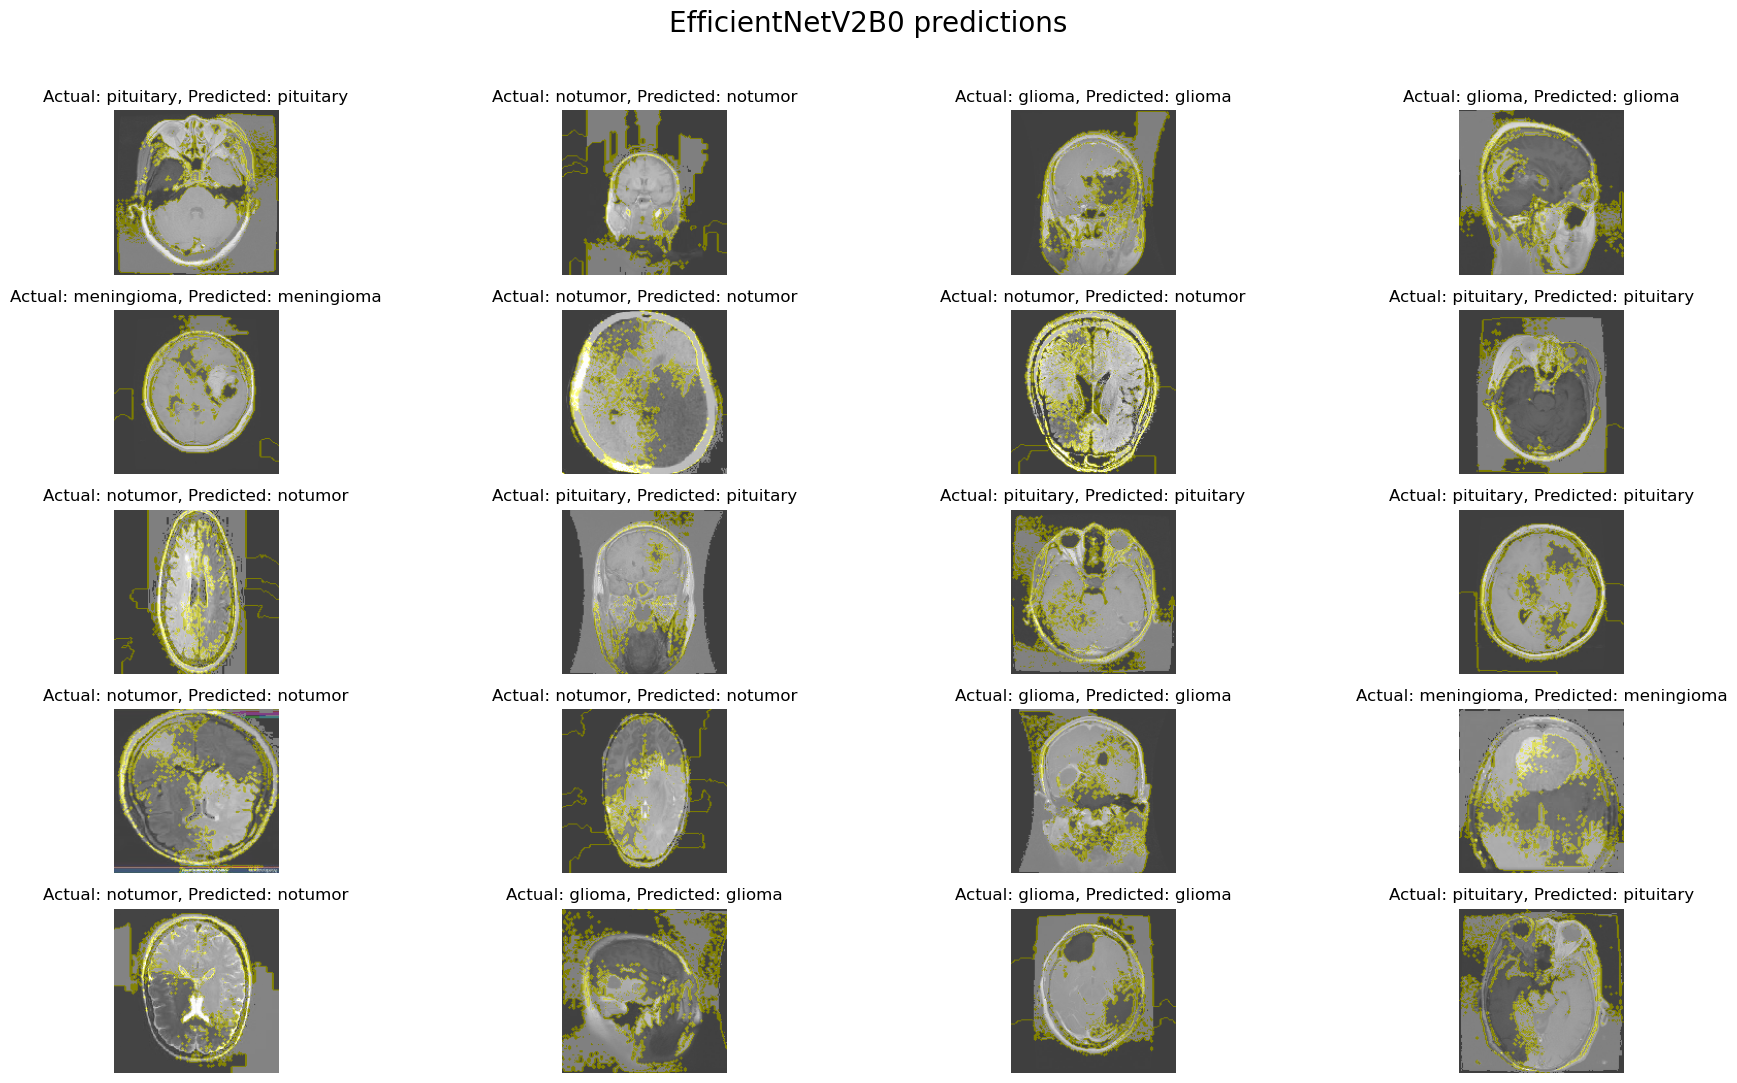

In [37]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

def predict_fn(images):
    return best_model.predict(images)


plt.figure(figsize=(20, 11))
plt.suptitle("EfficientNetV2B0 predictions", fontsize=20)

for i, (image, actual_class, predicted_class) in enumerate(zip(random_images, actual_classes, predicted_classes)):

    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))

    explanation = explainer.explain_instance(image, predict_fn, top_labels=4, num_samples=300)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=20, hide_rest=True)

    

    plt.subplot(columns, rows, i + 1)
    
    plt.imshow(normalized_image, alpha=1.0)
    
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), alpha=0.5)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




<h3> Lime MobileV</h3>

  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 234.69it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 60/300 [00:00<00:00, 242.15it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 90/300 [00:00<00:00, 247.88it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 120/300 [00:00<00:00, 246.55it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 150/300 [00:00<00:00, 246.23it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 180/300 [00:00<00:00, 243.64it/s]

1/1 [==============================] - 0s 11ms/step


 70%|███████   | 210/300 [00:00<00:00, 247.39it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 240/300 [00:00<00:00, 245.51it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████ | 270/300 [00:01<00:00, 244.89it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████| 300/300 [00:01<00:00, 245.82it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


 10%|█         | 30/300 [00:00<00:01, 261.18it/s]

1/1 [==============================] - 0s 13ms/step


 20%|██        | 60/300 [00:00<00:01, 231.46it/s]

1/1 [==============================] - 0s 11ms/step


 30%|███       | 90/300 [00:00<00:00, 241.93it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 120/300 [00:00<00:00, 247.54it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 150/300 [00:00<00:00, 249.70it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 180/300 [00:00<00:00, 248.26it/s]

1/1 [==============================] - 0s 12ms/step


 70%|███████   | 210/300 [00:00<00:00, 243.21it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 240/300 [00:00<00:00, 245.75it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████ | 270/300 [00:01<00:00, 249.53it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████| 300/300 [00:01<00:00, 245.79it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


 10%|█         | 30/300 [00:00<00:01, 256.03it/s]

1/1 [==============================] - 0s 11ms/step


 20%|██        | 60/300 [00:00<00:00, 248.35it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 90/300 [00:00<00:00, 248.25it/s]

1/1 [==============================] - 0s 13ms/step


 38%|███▊      | 115/300 [00:00<00:00, 243.36it/s]

1/1 [==============================] - 0s 11ms/step


 47%|████▋     | 140/300 [00:00<00:00, 226.79it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 170/300 [00:00<00:00, 237.40it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 237.36it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 230/300 [00:00<00:00, 242.68it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 260/300 [00:01<00:00, 244.39it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 290/300 [00:01<00:00, 242.75it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████| 300/300 [00:01<00:00, 241.89it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 30/300 [00:00<00:01, 241.62it/s]

1/1 [==============================] - 0s 11ms/step


 20%|██        | 60/300 [00:00<00:00, 246.17it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 90/300 [00:00<00:00, 247.74it/s]

1/1 [==============================] - 0s 13ms/step


 40%|████      | 120/300 [00:00<00:00, 248.94it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 150/300 [00:00<00:00, 252.47it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▊    | 176/300 [00:00<00:00, 248.27it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 201/300 [00:00<00:00, 235.41it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 230/300 [00:00<00:00, 236.46it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 260/300 [00:01<00:00, 240.59it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 290/300 [00:01<00:00, 245.71it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 244.55it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 30/300 [00:00<00:01, 250.27it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 60/300 [00:00<00:00, 258.39it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 90/300 [00:00<00:00, 258.63it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 120/300 [00:00<00:00, 256.57it/s]

1/1 [==============================] - 0s 11ms/step


 50%|█████     | 150/300 [00:00<00:00, 257.14it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 180/300 [00:00<00:00, 252.78it/s]

1/1 [==============================] - 0s 12ms/step


 70%|███████   | 210/300 [00:00<00:00, 252.93it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▊  | 236/300 [00:00<00:00, 247.07it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 261/300 [00:01<00:00, 239.69it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 290/300 [00:01<00:00, 237.63it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████| 300/300 [00:01<00:00, 247.17it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|▉         | 29/300 [00:00<00:00, 289.59it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 58/300 [00:00<00:00, 249.30it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 84/300 [00:00<00:00, 229.57it/s]

1/1 [==============================] - 0s 13ms/step


 37%|███▋      | 110/300 [00:00<00:00, 220.44it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 140/300 [00:00<00:00, 224.21it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 170/300 [00:00<00:00, 228.30it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 233.49it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 230/300 [00:00<00:00, 236.84it/s]

1/1 [==============================] - 0s 13ms/step


 85%|████████▍ | 254/300 [00:01<00:00, 235.73it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 280/300 [00:01<00:00, 225.58it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 231.39it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


 10%|█         | 30/300 [00:00<00:01, 246.84it/s]

1/1 [==============================] - 0s 11ms/step


 20%|██        | 60/300 [00:00<00:01, 237.90it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 90/300 [00:00<00:00, 240.56it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 120/300 [00:00<00:00, 241.68it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 150/300 [00:00<00:00, 240.65it/s]

1/1 [==============================] - 0s 12ms/step


 59%|█████▉    | 177/300 [00:00<00:00, 249.15it/s]

1/1 [==============================] - 0s 11ms/step


 68%|██████▊   | 203/300 [00:00<00:00, 236.95it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 227/300 [00:00<00:00, 224.96it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 250/300 [00:01<00:00, 209.88it/s]

1/1 [==============================] - 0s 14ms/step


 91%|█████████ | 272/300 [00:01<00:00, 202.40it/s]

1/1 [==============================] - 0s 12ms/step


 98%|█████████▊| 295/300 [00:01<00:00, 209.34it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████| 300/300 [00:01<00:00, 221.94it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


 10%|█         | 30/300 [00:00<00:01, 251.37it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 60/300 [00:00<00:00, 252.21it/s]

1/1 [==============================] - 0s 11ms/step


 30%|███       | 90/300 [00:00<00:00, 252.27it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 120/300 [00:00<00:00, 250.46it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 150/300 [00:00<00:00, 248.18it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████    | 180/300 [00:00<00:00, 235.86it/s]

1/1 [==============================] - 0s 13ms/step


 70%|███████   | 210/300 [00:00<00:00, 237.14it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 240/300 [00:00<00:00, 237.55it/s]

1/1 [==============================] - 0s 12ms/step


 90%|█████████ | 270/300 [00:01<00:00, 242.67it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 295/300 [00:01<00:00, 242.66it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 300/300 [00:01<00:00, 238.37it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


 10%|▉         | 29/300 [00:00<00:00, 289.32it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 58/300 [00:00<00:00, 244.38it/s]

1/1 [==============================] - 0s 13ms/step


 28%|██▊       | 83/300 [00:00<00:00, 218.76it/s]

1/1 [==============================] - 0s 13ms/step


 37%|███▋      | 110/300 [00:00<00:00, 211.85it/s]

1/1 [==============================] - 0s 14ms/step


 46%|████▌     | 137/300 [00:00<00:00, 229.47it/s]

1/1 [==============================] - 0s 13ms/step


 54%|█████▎    | 161/300 [00:00<00:00, 210.21it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 190/300 [00:00<00:00, 215.94it/s]

1/1 [==============================] - 0s 13ms/step


 73%|███████▎  | 220/300 [00:00<00:00, 219.30it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 250/300 [00:01<00:00, 222.03it/s]

1/1 [==============================] - 0s 14ms/step


 92%|█████████▏| 277/300 [00:01<00:00, 234.03it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████| 300/300 [00:01<00:00, 220.00it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 30/300 [00:00<00:01, 238.62it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 60/300 [00:00<00:00, 246.50it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 90/300 [00:00<00:00, 241.29it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 120/300 [00:00<00:00, 240.68it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 150/300 [00:00<00:00, 246.90it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 180/300 [00:00<00:00, 251.98it/s]

1/1 [==============================] - 0s 12ms/step


 70%|███████   | 210/300 [00:00<00:00, 250.88it/s]

1/1 [==============================] - 0s 11ms/step


 80%|████████  | 240/300 [00:00<00:00, 253.36it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████ | 270/300 [00:01<00:00, 256.79it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 250.25it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 30/300 [00:00<00:01, 235.03it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 60/300 [00:00<00:00, 242.81it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 90/300 [00:00<00:00, 245.39it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 120/300 [00:00<00:00, 240.30it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 150/300 [00:00<00:00, 241.27it/s]

1/1 [==============================] - 0s 13ms/step


 60%|██████    | 180/300 [00:00<00:00, 237.01it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 210/300 [00:00<00:00, 226.04it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 240/300 [00:01<00:00, 228.29it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 263/300 [00:01<00:00, 222.96it/s]

1/1 [==============================] - 0s 13ms/step


 97%|█████████▋| 290/300 [00:01<00:00, 215.25it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 228.18it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 30/300 [00:00<00:01, 234.89it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 60/300 [00:00<00:01, 233.80it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 90/300 [00:00<00:00, 239.45it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 120/300 [00:00<00:00, 238.04it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 150/300 [00:00<00:00, 240.43it/s]

1/1 [==============================] - 0s 11ms/step


 60%|██████    | 180/300 [00:00<00:00, 242.64it/s]

1/1 [==============================] - 0s 11ms/step


 70%|███████   | 210/300 [00:00<00:00, 244.15it/s]

1/1 [==============================] - 0s 12ms/step


 80%|████████  | 240/300 [00:00<00:00, 243.70it/s]

1/1 [==============================] - 0s 11ms/step


 90%|█████████ | 270/300 [00:01<00:00, 238.21it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 294/300 [00:01<00:00, 233.97it/s]

1/1 [==============================] - 0s 14ms/step


100%|██████████| 300/300 [00:01<00:00, 235.04it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 30/300 [00:00<00:01, 233.31it/s]

1/1 [==============================] - 0s 13ms/step


 19%|█▉        | 58/300 [00:00<00:00, 257.43it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 85/300 [00:00<00:00, 232.92it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 110/300 [00:00<00:00, 218.63it/s]

1/1 [==============================] - 0s 14ms/step


 46%|████▋     | 139/300 [00:00<00:00, 240.59it/s]

1/1 [==============================] - 0s 11ms/step


 55%|█████▍    | 164/300 [00:00<00:00, 224.23it/s]

1/1 [==============================] - 0s 11ms/step


 63%|██████▎   | 190/300 [00:00<00:00, 219.15it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 220/300 [00:00<00:00, 222.39it/s]

1/1 [==============================] - 0s 11ms/step


 83%|████████▎ | 250/300 [00:01<00:00, 224.53it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 279/300 [00:01<00:00, 241.24it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████| 300/300 [00:01<00:00, 226.98it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 30/300 [00:00<00:01, 247.71it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 60/300 [00:00<00:00, 241.22it/s]

1/1 [==============================] - 0s 12ms/step


 30%|██▉       | 89/300 [00:00<00:00, 260.88it/s]

1/1 [==============================] - 0s 12ms/step


 39%|███▊      | 116/300 [00:00<00:00, 244.37it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 141/300 [00:00<00:00, 221.62it/s]

1/1 [==============================] - 0s 12ms/step


 57%|█████▋    | 170/300 [00:00<00:00, 226.05it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 225.83it/s]

1/1 [==============================] - 0s 11ms/step


 77%|███████▋  | 230/300 [00:00<00:00, 231.25it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 260/300 [00:01<00:00, 234.53it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 290/300 [00:01<00:00, 236.22it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████| 300/300 [00:01<00:00, 235.30it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 20/300 [00:00<00:01, 192.66it/s]

1/1 [==============================] - 0s 12ms/step


 17%|█▋        | 50/300 [00:00<00:01, 220.82it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 80/300 [00:00<00:00, 225.37it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 110/300 [00:00<00:00, 235.33it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 140/300 [00:00<00:00, 228.55it/s]

1/1 [==============================] - 0s 14ms/step


 54%|█████▍    | 163/300 [00:00<00:00, 226.42it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 190/300 [00:00<00:00, 227.63it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████▎  | 220/300 [00:00<00:00, 232.47it/s]

1/1 [==============================] - 0s 11ms/step


 83%|████████▎ | 250/300 [00:01<00:00, 239.94it/s]

1/1 [==============================] - 0s 11ms/step


 93%|█████████▎| 280/300 [00:01<00:00, 246.70it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 235.39it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 30/300 [00:00<00:01, 253.14it/s]

1/1 [==============================] - 0s 12ms/step


 20%|█▉        | 59/300 [00:00<00:00, 273.26it/s]

1/1 [==============================] - 0s 12ms/step


 29%|██▉       | 87/300 [00:00<00:00, 249.43it/s]

1/1 [==============================] - 0s 13ms/step


 38%|███▊      | 113/300 [00:00<00:00, 234.20it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 140/300 [00:00<00:00, 229.82it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 164/300 [00:00<00:00, 231.48it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 190/300 [00:00<00:00, 220.70it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 220/300 [00:00<00:00, 227.44it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 250/300 [00:01<00:00, 235.23it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 280/300 [00:01<00:00, 239.40it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████| 300/300 [00:01<00:00, 237.99it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 26/300 [00:00<00:01, 257.92it/s]

1/1 [==============================] - 0s 11ms/step


 17%|█▋        | 52/300 [00:00<00:01, 224.77it/s]

1/1 [==============================] - 0s 12ms/step


 27%|██▋       | 80/300 [00:00<00:00, 227.75it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 110/300 [00:00<00:00, 235.40it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 140/300 [00:00<00:00, 233.86it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 170/300 [00:00<00:00, 220.82it/s]

1/1 [==============================] - 0s 13ms/step


 64%|██████▍   | 193/300 [00:00<00:00, 221.31it/s]

1/1 [==============================] - 0s 11ms/step


 73%|███████▎  | 220/300 [00:00<00:00, 221.48it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 250/300 [00:01<00:00, 226.78it/s]

1/1 [==============================] - 0s 11ms/step


 93%|█████████▎| 280/300 [00:01<00:00, 231.17it/s]

1/1 [==============================] - 0s 11ms/step


100%|██████████| 300/300 [00:01<00:00, 229.52it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


 10%|█         | 30/300 [00:00<00:01, 231.48it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 60/300 [00:00<00:01, 238.60it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 90/300 [00:00<00:00, 239.73it/s]

1/1 [==============================] - 0s 12ms/step


 40%|████      | 120/300 [00:00<00:00, 242.23it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 150/300 [00:00<00:00, 241.15it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 175/300 [00:00<00:00, 240.68it/s]

1/1 [==============================] - 0s 12ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 224.16it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 230/300 [00:00<00:00, 229.10it/s]

1/1 [==============================] - 0s 12ms/step


 87%|████████▋ | 260/300 [00:01<00:00, 228.93it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 290/300 [00:01<00:00, 234.72it/s]

1/1 [==============================] - 0s 12ms/step


100%|██████████| 300/300 [00:01<00:00, 235.03it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|▉         | 29/300 [00:00<00:00, 289.54it/s]

1/1 [==============================] - 0s 13ms/step


 19%|█▉        | 58/300 [00:00<00:01, 231.69it/s]

1/1 [==============================] - 0s 13ms/step


 27%|██▋       | 82/300 [00:00<00:01, 209.82it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 110/300 [00:00<00:00, 210.05it/s]

1/1 [==============================] - 0s 12ms/step


 47%|████▋     | 140/300 [00:00<00:00, 217.20it/s]

1/1 [==============================] - 0s 14ms/step


 56%|█████▌    | 167/300 [00:00<00:00, 232.18it/s]

1/1 [==============================] - 0s 12ms/step


 64%|██████▎   | 191/300 [00:00<00:00, 209.72it/s]

1/1 [==============================] - 0s 12ms/step


 73%|███████▎  | 220/300 [00:00<00:00, 220.63it/s]

1/1 [==============================] - 0s 12ms/step


 83%|████████▎ | 250/300 [00:01<00:00, 228.37it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 280/300 [00:01<00:00, 232.79it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 226.09it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 13ms/step


 10%|█         | 30/300 [00:00<00:01, 235.14it/s]

1/1 [==============================] - 0s 12ms/step


 20%|██        | 60/300 [00:00<00:01, 228.35it/s]

1/1 [==============================] - 0s 12ms/step


 30%|███       | 90/300 [00:00<00:00, 231.58it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 120/300 [00:00<00:00, 239.20it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 150/300 [00:00<00:00, 241.40it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 175/300 [00:00<00:00, 243.50it/s]

1/1 [==============================] - 0s 11ms/step


 67%|██████▋   | 200/300 [00:00<00:00, 224.88it/s]

1/1 [==============================] - 0s 13ms/step


 77%|███████▋  | 230/300 [00:00<00:00, 228.38it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 253/300 [00:01<00:00, 228.68it/s]

1/1 [==============================] - 0s 12ms/step


 93%|█████████▎| 280/300 [00:01<00:00, 227.01it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 300/300 [00:01<00:00, 229.92it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


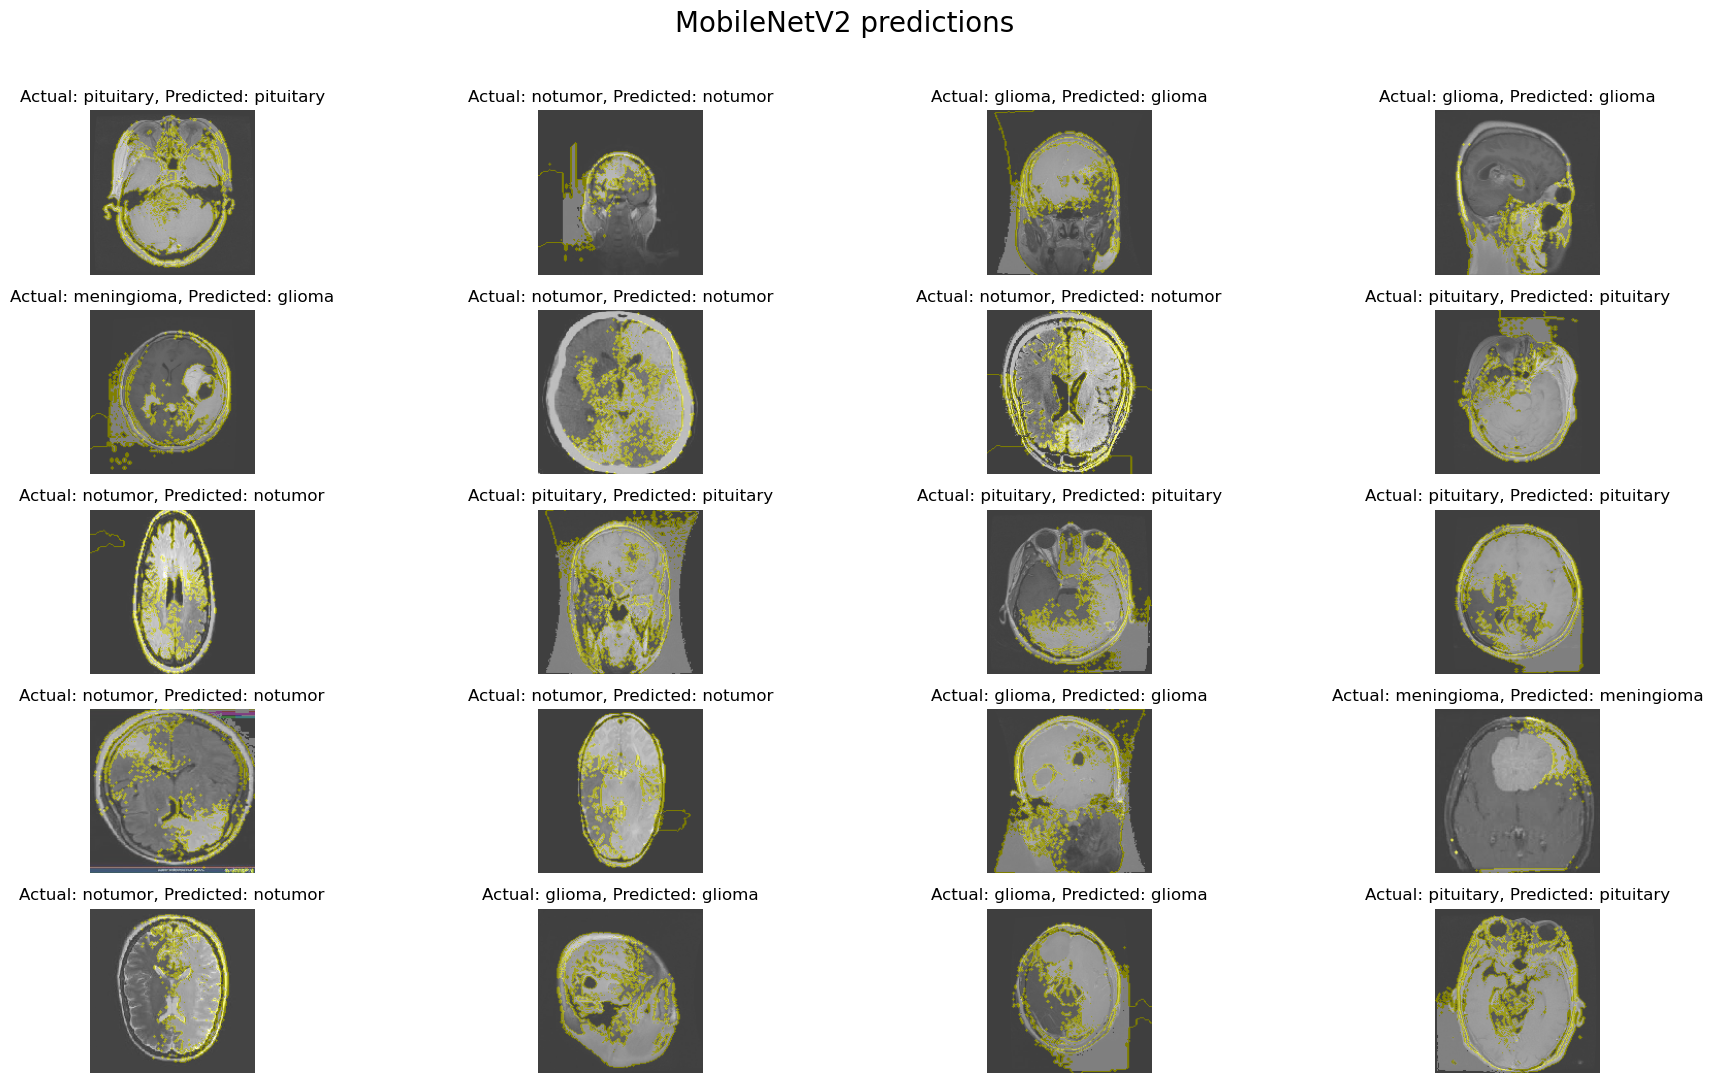

In [38]:
def MobileNetV2_predict_fn(images):
    return best_MobileNetV2_model.predict(images)

plt.figure(figsize=(20, 11))
plt.suptitle("MobileNetV2 predictions", fontsize=20)

for i, (image, actual_class, predicted_class) in enumerate(zip(random_images, actual_classes, MobileNetV2_predicted_classes)):

    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))

    explanation = explainer.explain_instance(image, MobileNetV2_predict_fn, top_labels=4, num_samples=300)

    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)

    plt.subplot(columns, rows, i + 1)
    
    plt.imshow(normalized_image, alpha=1.0)
    
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), alpha=0.5)
    
    plt.title(f"Actual: {class_names[actual_class]}, Predicted: {class_names[predicted_class]}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()